# LIBRERIE

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import itertools
from pyvis.network import Network
import os
import shutil
import collections
import random
import numpy as np

In [2]:
import os

cartella = "GeeksforGeeks"
  
# Parent Directory path
percorso_cartella = "/Users/emanuele/Desktop/SNA/PROGETTO"

path = os.path.join(percorso_cartella, cartella)
os.mkdir(path)

print("La cartella '% s' è stata creata con successo" % cartella)

FileExistsError: [Errno 17] File exists: '/Users/emanuele/Desktop/SNA/PROGETTO/GeeksforGeeks'

# DATASET

In [3]:
dataset = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/DATASET/CosciaRios2012_DataBase.csv') #lettura del dataset
dataset.drop('Code', axis=1, inplace=True) #rimuoviamo la collona dove sono presenti i codici "provinciali"
dataset = dataset.groupby(['State','Year']).sum() #sommiamo le nostre istanze in base a Stato e Anno
dataset.to_csv('Mexican_Drug_Cartels_dta.csv') #salviamo il dataset

#cambiamo la posizione del file creato
source = r"/Users/emanuele/Desktop/SNA/PROGETTO/Mexican_Drug_Cartels_dta.csv"
destination = r"/Users/emanuele/Desktop/SNA/PROGETTO/DATASET/Mexican_Drug_Cartels_dta.csv"
shutil.move(source, destination)

'/Users/emanuele/Desktop/SNA/PROGETTO/DATASET/Mexican_Drug_Cartels_dta.csv'

In [4]:
dataset = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/DATASET/Mexican_Drug_Cartels_dta.csv')
#dividiamo il nostro datastet in due decadi 
dta_9000 = dataset[dataset.Year < 2000] #1990-1999
dta_0010 = dataset[dataset.Year >= 2000 ] #2000-2010

# FUNZIONI

In [5]:
def Edges_Generator(dataset, name_txt, Qcartelli, stateL=False, yearL=False, yearXstate=False, cartelL=False,
                    link_state_year=False):
    #permette la creazione di edges partendo dal dataset di partenza

    #esegue un check per vedere crearli su tutte le famiglie o su una in particolare
    if Qcartelli == 'ALL':
        cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                    'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']
    else:
        cartelli = []
        cartelli.append(Qcartelli)

    res_list = []
    
    for state in dataset.State.unique(): #creiuamo un subset per ogni stato in maniera ricorsiva
        sub1 = dataset[dataset.State == state]

        for year in sub1.Year: #creiuamo un subset per ogni anno in maniera ricorsiva
            sub2 = sub1[sub1.Year == year]
            
            for single in cartelli:
                value = sub2[single].iloc[0] #troviamo il numero di volte che il cartello è apparso
                list = []

                if value > 0 : #eseguiamo un controllo per sapere se creare o no il collegamento
                    #in base alle impostazioni decise prendiamo PARTENZA(A), ARRIVO(B) e WEIGHT(W)
                    if yearXstate == True:
                        year_ = str(year)
                        _state = str(state)
                        year_state = str(year_ + '_' + _state)

                    if stateL == True:
                        list.append(state)
                    
                    if yearL == True:
                        list.append(year)
                    elif yearXstate == True:
                        list.append(year_state)
                    
                    if Qcartelli == 'ALL':
                        if cartelL == True:
                            list.append(single)
                    else:
                        if cartelL == True:
                            list.append(Qcartelli)
                    
                    if link_state_year == True:
                        list.append(1)
                    else:
                        list.append(value)
                    res_list.append(list)

    #creiamo il file.txt con il nome deciso nelle impostazioni                    
    name_file = str(name_txt + ".txt")
    file = open(name_file, "w+")

    file.write('A'+',')
    file.write('B'+',')
    file.write('Weight'+'\n')

    for list in res_list:
        time = 0
        for element in list:
            time = time + 1
            e = str(element)
            file.write(e)
            if time < 3:
                file.write(',')
            else:
                file.write('\n')

    file.close()

    return(file)

#----------------------------------------------------------------------------------------#

def Edges_Generator_for_Cartel(name_cartel, cartel_sigla, years_9000=False, years_0010=False):

    if years_9000 == True: #svolgo operazioni per gli anni 1990 - 1999
        #assegno i nomi ai file tramite una concatenazione di stringhe
        name_txt_9000_yXc = 'year_'+str(name_cartel)+'_'+str(cartel_sigla)+'9000'
        name_txt_9000_sXy = 'state_year_'+str(name_cartel)+'_'+str(cartel_sigla)+'9000'
        name_csv_9000 = str(name_cartel)+'_'+'9000'+'.csv'

        #utilizzo la funzione creata in precesenza per generare gli edges
        Edges_Generator(dta_9000,name_txt_9000_yXc, name_cartel, yearL=True,cartelL=True)
        Edges_Generator(dta_9000,name_txt_9000_sXy, name_cartel, stateL=True, yearL=True,link_state_year=True)

        name_txt_9000_yXc = name_txt_9000_yXc + '.txt'
        name_txt_9000_sXy = name_txt_9000_sXy + '.txt'

        #creo i percorsi delle per leggeere i file.txt sopra creati
        percorso_cartella = '/Users/emanuele/Desktop/SNA/PROGETTO/'
        percorso_1 = str(percorso_cartella) + str(name_txt_9000_sXy)
        percorso_2 = str(percorso_cartella) + str(name_txt_9000_yXc)
        percorso_3 = str(percorso_cartella) + str(name_csv_9000)

        df_1 = pd.read_csv(str(percorso_1))
        df_2 = pd.read_csv(str(percorso_2))
        df_2 = df_2.groupby(['A','B']).sum() #effettuo una somma in base ad anno e cartello
        df_2.to_csv(name_csv_9000) 
        df_2 = pd.read_csv(percorso_3)
        df = pd.concat([df_1,df_2],ignore_index=True, sort=False) #unisco le due liste di edges
    
    elif years_0010 == True: #svolgo le stesse operazioni per gli anni fra 2000 e 2010
        name_txt_0010_yXc = 'year_'+str(name_cartel)+'_'+str(cartel_sigla)+'0010'
        name_txt_0010_sXy = 'state_year_'+str(name_cartel)+'_'+str(cartel_sigla)+'0010'
        name_csv_0010 = str(name_cartel)+'_'+'0010'+'.csv'

        Edges_Generator(dta_0010,name_txt_0010_yXc, name_cartel, yearL=True,cartelL=True)
        Edges_Generator(dta_0010,name_txt_0010_sXy, name_cartel, stateL=True, yearL=True,link_state_year=True)

        name_txt_0010_yXc = name_txt_0010_yXc + '.txt'
        name_txt_0010_sXy = name_txt_0010_sXy + '.txt'

        percorso_cartella = '/Users/emanuele/Desktop/SNA/PROGETTO/'
        percorso_1 = str(percorso_cartella) + str(name_txt_0010_sXy)
        percorso_2 = str(percorso_cartella) + str(name_txt_0010_yXc)
        percorso_3 = str(percorso_cartella) + str(name_csv_0010)

        df_1 = pd.read_csv(str(percorso_1))
        df_2 = pd.read_csv(str(percorso_2))
        df_2 = df_2.groupby(['A','B']).sum()
        df_2.to_csv(name_csv_0010)
        df_2 = pd.read_csv(percorso_3)
        df = pd.concat([df_1,df_2],ignore_index=True, sort=False) 

    return(df)

#----------------------------------------------------------------------------------------#

def Edges_Only_Cartel_Network_Start(dataset,name_txt):
    
    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

    final_list = []
    for state in dataset.State.unique():
        sub1 = dataset[dataset.State == state]

        for year in sub1.Year:
            sub2 = sub1[sub1.Year == year]
            
            for single in cartelli:
                value = sub2[single].iloc[0]
                list = []
                if value > 0 :
                    list.append(state)
                    list.append(year)
                    list.append(single)
                    list.append(value)
                    final_list.append(list)
                    
    name_file = str(name_txt + ".txt")
    file = open(name_file, "w+")

    file.write('A'+',')
    file.write('Bridge'+',')
    file.write('B'+',')
    file.write('Weight'+'\n')

    for list in final_list:
        time = 0
        for element in list:
            time = time + 1
            e = str(element)
            file.write(e)
            if time < 4:
                file.write(',')
            else:
                file.write('\n')

    file.close() 

    return(file)

#----------------------------------------------------------------------------------------#

def Edges_Only_Cartel_Network_Final(dataset, name_txt, name_csv, year_selected):

    Edges_Only_Cartel_Network_Start(dataset,name_txt)

    name_file_txt = name_txt+'.txt'
    name_file_csv = name_csv+'.csv'
    percorso_cartella = '/Users/emanuele/Desktop/SNA/PROGETTO/'
    percorso1 = percorso_cartella + name_file_txt
    percorso2 = percorso_cartella + name_file_csv

    data =  pd.read_csv(percorso1)

    data = data[data.Bridge == year_selected]

    data_AB = data[['A','B','Weight']]
    data_AB = data_AB.groupby(['A','B']).sum()

    data_AB.to_csv(name_file_csv)

    df = pd.read_csv(percorso2)

    edges_list = []

    for state in df.A.unique():
        sub = df[df.A == state]
        
        if len(sub) > 1:
            list_cartels = []
            for cartel in sub.B:
                list_cartels.append(cartel)

            for v in itertools.combinations(list_cartels, 2):
                edges_list.append(v)
                
                
    new_df = pd.DataFrame(columns=['A','B'])
    new_df[['A','B']]=edges_list

    new_cols = ['A','B']
    new_df = new_df.reindex(new_df.columns.union(new_cols), axis=1) 

    return(new_df)

#----------------------------------------------------------------------------------------#

def Network_Cartels_Meeting_Generator(dataset,Graph,colore):
    
    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']
    
    edges_cartels = dataset.values.tolist()

    for cartello in cartelli:
        name = str(cartello)
        Graph.add_node(name, color = colore)

    for i in range(len(edges_cartels)):
        edge = edges_cartels[i]
        add = -1

        for o in range(len(edge)):
            add = add + 1
            
            if add == 0:
                A = edge[add]
                
            elif add == 1:
                B = edge[add]
            elif add == 2:
                W = edge[add]

        Graph.add_edge(str(A), str(B) ,weight=int(W))
          
    return(Graph)   

#----------------------------------------------------------------------------------------#

def metrics(network, link_select=False, nodi_select=False, degree_select=False, density_select=False, matrix_select=False,
betweenness_select=False, closeness_select=False, eigen_select=False, all_metrics=False):

    if all_metrics == True:
        link_select = True
        nodi_select = True
        degree_select = True
        density_select = True
        matrix_select = True
        betweenness_select = True 
        closeness_select = True
        eigen_select = True

    #CONTO DEGLI EDGE/LINK DELLA RETE 
    if link_select == True:
        l = network.number_of_edges()
        print('Gli edge della rete sono:', l)
    
    #CONTO I NODI DELLA RETE
    if nodi_select == True:
        nodi = network.number_of_nodes()
        print('#','-'*60,'#')
        print('I nodi della rete sono:',nodi)

    #DEGREE DEI NODI 
    if degree_select == True:
        print('#','-'*60,'#')
        list = []
        for node in network.degree():
            list.append(node)
        nodi_degree = pd.DataFrame(list, columns = ['Node', 'Degree'])
        nodi_degree.to_csv('nodi_degree.csv')
        

        somma_degree = sum(dict(network.degree()).values())
        print('La somma dei node degree è:',somma_degree)
        print('\nL\'average degree di questa network è:',somma_degree/(len(network)))
        print('\nI valori degree maggiori sono:', '\n', nodi_degree.nlargest(5, 'Degree'))
    
    #DENSITA'
    if density_select == True:
        print('#','-'*60,'#')
        print('Densità della rete equivale a:',nx.density(network))

    #MATRICE DI ADIACENZA PESATA
    if matrix_select == True:
        print('#','-'*60,'#')
        print('La Matrice di adiacenza pesata è stata salvata correttamente.') 
        m = nx.to_pandas_adjacency(network, nodelist=sorted(network.nodes), dtype=int)
        m.to_excel('adjacency_matrix.xlsx')

    #BETWEENNESS CENTRALITY
    if betweenness_select == True:
        B = nx.betweenness_centrality(network,normalized=False)
        print('#','-'*60,'#')
        list_bet = []
        for value in B.items():
            list_bet.append(value)
        bet_value = pd.DataFrame(list_bet, columns = ['Node', 'Values'])
        bet_value.to_csv('Betweenness_value.csv')
        print('I valori della Betweenness maggiori sono:', '\n', bet_value.nlargest(5, 'Values'))
    
    #CLOSENESS CENTRALITY
    if closeness_select == True:
        C = nx.closeness_centrality(network)
        print('#','-'*60,'#')
        list_clo = []
        for value in C.items():
            list_clo.append(value)
        clo_value = pd.DataFrame(list_clo, columns = ['Node', 'Values'])
        clo_value.to_csv('Closeness_value.csv')
        print('I valori della Closeness maggiori sono:', '\n', clo_value.nlargest(5, 'Values'))
    
    #EIGENVECTOR CENTRALITY
    if eigen_select == True:
        eigen = nx.eigenvector_centrality(network)
        print('#','-'*60,'#')
        list_eigen = []
        for value in eigen.items():
            list_eigen.append(value)
        eig_value = pd.DataFrame(list_eigen, columns = ['Node', 'Values'])
        eig_value.to_csv('Eigenvector_value.csv')
        print('I valori dell\'Eigenvector maggiori sono:', '\n', eig_value.nlargest(5, 'Values'))

#----------------------------------------------------------------------------------------#

def BiGram_Generator_Counter(dataset):

    dataset['to'] = '-'
    add = dataset.A +dataset.to+ dataset.B
    dataset['bi-grams'] = add

    list_ = add.values.tolist()

    frequency = collections.Counter(list_)

    list_f = list(frequency.items())

    cartels_connections = []
    W = []
    A = []
    B = []
    for i in range(len(list_f)):
        cartels_connections.append(list_f[i][0])
        W.append(list_f[i][1])
        A.append(cartels_connections[i].split('-')[0])
        B.append(cartels_connections[i].split('-')[1])
    
    final = pd.DataFrame()
    final['A'] = A
    final['B'] = B
    final['W'] = W
    
    return(final)

#----------------------------------------------------------------------------------------#

def Network_Generator_For_Cartels(Graph,state_year_csv,df_cartel,name_cartel):

    state_year = state_year_csv
    for a in state_year.A.unique():
        name = str(a)
        Graph.add_node(name, color = 'green')

    for b in state_year.B.unique():
        name = str(b)
        Graph.add_node(name, color = 'blue')

    Graph.add_node(name_cartel, color = 'red')

    list_df = df_cartel.values.tolist()
    f = len(list_df)

    for s in range(f):
        edge = list_df[s]
        add = -1

        for x in range(len(edge)):
            add = add + 1
            
            if add == 0:
                A = edge[add]
                
            elif add == 1:
                B = edge[add]
                
            elif add == 2 :
                W = edge[add]

        Graph.add_edge(str(A), str(B) ,weight=int(W))

    return(Graph)

#----------------------------------------------------------------------------------------#

def html_network(net,data,yearXstate_txt): 
    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

    yearXstate = yearXstate_txt
    stati = yearXstate.A.unique().astype(str)
    yearXstate = yearXstate.B.unique()

    net.barnes_hut()
    data_ = data

    sources = data_['B']
    targets = data_['A']
    weights = data_['Weight']

    edge_data = zip(sources, targets, weights)

    for cartel in cartelli:
        net.add_node(cartel,color='red',color_border='black')

    for stato in stati:
        net.add_node(stato,color='green')

    for y_s in yearXstate:
        net.add_node(y_s,color='blue')

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]
        
        net.add_node(dst, dst, title=dst)
        net.add_edge(src, dst, value=w,opacity=0.1)

    neighbor_map = net.get_adj_list()

    net.repulsion(node_distance=200, spring_length=80)

    for node in net.nodes:
        node['value'] = len(neighbor_map[node['id']])

    net.show_buttons(filter_=True)
    return(net)

# NETWORK VISUALIZATION

## GENERAL

In [5]:
Edges_Generator(dta_9000,'G_yearXstate_cartel_9000','ALL',yearXstate=True,cartelL=True) #G_yearXstate_cartel_9000
Edges_Generator(dta_9000,'G_state_yearXstate_9000','ALL',stateL=True, yearXstate=True) #G_state_yearXstate_9000
df_1 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_state_yearXstate_9000.txt')
df_2 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_yearXstate_cartel_9000.txt')
df_9000 = pd.concat([df_1,df_2],ignore_index=True, sort=False)


Edges_Generator(dta_0010,'G_yearXstate_cartel_0010','ALL',yearXstate=True,cartelL=True) #G_yearXstate_cartel_0010
Edges_Generator(dta_0010,'G_state_yearXstate_0010','ALL',stateL=True, yearXstate=True) #G_state_yearXstate_0010
df_1 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_state_yearXstate_0010.txt')
df_2 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_yearXstate_cartel_0010.txt')
df_0010 = pd.concat([df_1,df_2],ignore_index=True, sort=False)

In [6]:
df_9000['A'] = df_9000.A.astype(str)
df_0010['A'] = df_0010.A.astype(str)

In [7]:
net_9000 = Network(height='750px', width='100%', bgcolor='white', font_color='black')
yearXstate_9000= pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_state_yearXstate_9000.txt')
html_network(net_9000,df_9000,yearXstate_9000)
net_9000.show('networkDTO_9000.html')

In [8]:
net_0010 = Network(height='750px', width='100%', bgcolor='white', font_color='black')
yearXstate_0010 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/G_state_yearXstate_0010.txt')
html_network(net_0010,df_0010,yearXstate_0010)
net_0010.show('networkDTO_0010.html')

In [9]:
netX_9000 = nx.Graph()

netX_data_9000 = df_9000

cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

stati = yearXstate_9000.A.unique()
yearXstate_9000 = yearXstate_9000.B.unique()

for a in stati:
    name = str(a)
    netX_9000.add_node(name, color = 'red')

for b in yearXstate_9000:
    name = str(b)
    netX_9000.add_node(name, color = 'blue')

for cartel in cartelli:
    netX_9000.add_node(cartel, color = 'green')

list_df = netX_data_9000.values.tolist()
f = len(list_df)

for s in range(f):
    edge = list_df[s]
    add = -1

    for x in range(len(edge)):
        add = add + 1
        
        if add == 0:
            A = edge[add]
            
        elif add == 1:
            B = edge[add]
            
        elif add == 2 :
            W = edge[add]

    netX_9000.add_edge(str(A), str(B) ,weight=int(W))

In [10]:
netX_0010 = nx.Graph()

netX_data_0010 = df_0010

cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

stati = yearXstate_0010.A.unique()
yearXstate_0010= yearXstate_0010.B.unique()

for a in stati:
    name = str(a)
    netX_0010.add_node(name, color = 'red')

for b in yearXstate_0010:
    name = str(b)
    netX_0010.add_node(name, color = 'blue')

for cartel in cartelli:
    netX_0010.add_node(cartel, color = 'green')

list_df = netX_data_0010.values.tolist()
f = len(list_df)

for s in range(f):
    edge = list_df[s]
    add = -1

    for x in range(len(edge)):
        add = add + 1
        
        if add == 0:
            A = edge[add]
            
        elif add == 1:
            B = edge[add]
            
        elif add == 2 :
            W = edge[add]

    netX_0010.add_edge(str(A), str(B) ,weight=int(W))

In [14]:
metrics(netX_9000,link_select=True, nodi_select=True, degree_select=True, density_select=True, matrix_select=True,
betweenness_select=True) 

Gli edge della rete sono: 309
# ------------------------------------------------------------ #
I nodi della rete sono: 164
# ------------------------------------------------------------ #
La somma dei node degree è: 618

L'average degree di questa network è: 3.768292682926829

I valori degree maggiori sono: 
         Node  Degree
158   Juarez      43
161  Tijuana      42
157    Golfo      40
159  Sinaloa      35
162    Zetas      22
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.02311836001795601
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness maggiori sono: 
         Node       Values
161  Tijuana  4284.084731
158   Juarez  4205.582654
157    Golfo  3802.309688
159  Sinaloa  2895.074523
162    Zetas  1994.358347


In [15]:
metrics(netX_0010,link_select=True, nodi_select=True, degree_select=True, density_select=True, matrix_select=True,
betweenness_select=True)

Gli edge della rete sono: 1647
# ------------------------------------------------------------ #
I nodi della rete sono: 348
# ------------------------------------------------------------ #
La somma dei node degree è: 3294

L'average degree di questa network è: 9.46551724137931

I valori degree maggiori sono: 
               Node  Degree
341          Golfo     213
343        Sinaloa     212
346          Zetas     194
338  Beltran_Leyva     149
342         Juarez     145
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.02727814766968101
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness maggiori sono: 
         Node        Values
343  Sinaloa  15665.324366
341    Golfo  14801.747090
346    Zetas  10597.489151
345  Tijuana   7379.183875
342   Juarez   7227.815133


## PER FAMIGLIA

In [6]:
#1990-1999: in alcuni non sono presenti dati quindi decidiamo di non eseguire la creazione 
#df_BL9000 = Edges_Generator_for_Cartel('Beltran_Leyva','BL',years_9000=True)
#df_BLF9000 = Edges_Generator_for_Cartel('Beltran_Leyva_Family','BLF',years_9000=True)
#df_F9000 = Edges_Generator_for_Cartel('Familia','F',years_9000=True)
df_G9000 = Edges_Generator_for_Cartel('Golfo','G',years_9000=True)
df_J9000 = Edges_Generator_for_Cartel('Juarez','J',years_9000=True)
df_S9000 = Edges_Generator_for_Cartel('Sinaloa','S',years_9000=True)
#df_SF9000 = Edges_Generator_for_Cartel('Sinaloa_Family','SF',years_9000=True)
df_T9000 = Edges_Generator_for_Cartel('Tijuana','T',years_9000=True)
df_Z9000 = Edges_Generator_for_Cartel('Zetas','Z',years_9000=True)
#df_O9000 = Edges_Generator_for_Cartel('Otros','O',years_9000=True)

In [7]:
#2000-2010
df_BL0010 = Edges_Generator_for_Cartel('Beltran_Leyva','BL',years_0010=True)
df_BLF0010 = Edges_Generator_for_Cartel('Beltran_Leyva_Family','BLF',years_0010=True)
df_F0010 = Edges_Generator_for_Cartel('Familia','F',years_0010=True)
df_G0010 = Edges_Generator_for_Cartel('Golfo','G',years_0010=True)
df_J0010 = Edges_Generator_for_Cartel('Juarez','J',years_0010=True)
df_S0010 = Edges_Generator_for_Cartel('Sinaloa','S',years_0010=True)
df_SF0010 = Edges_Generator_for_Cartel('Sinaloa_Family','SF',years_0010=True)
df_T0010 = Edges_Generator_for_Cartel('Tijuana','T',years_0010=True)
df_Z0010 = Edges_Generator_for_Cartel('Zetas','Z',years_0010=True)
df_O0010 = Edges_Generator_for_Cartel('Otros','O',years_0010=True)

### Golfo

In [9]:
net_golfo_9000 = nx.Graph()
sXy_golfo_9000 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/state_year_Golfo_G9000.txt')
Network_Generator_For_Cartels(net_golfo_9000,sXy_golfo_9000,df_G9000,'Golfo')

In [22]:
nt = Network('1000px', '1000px')
nt.from_nx(net_golfo_9000, default_edge_weight=3,show_edge_weights=True)
nt.show('golfo_9000.html')

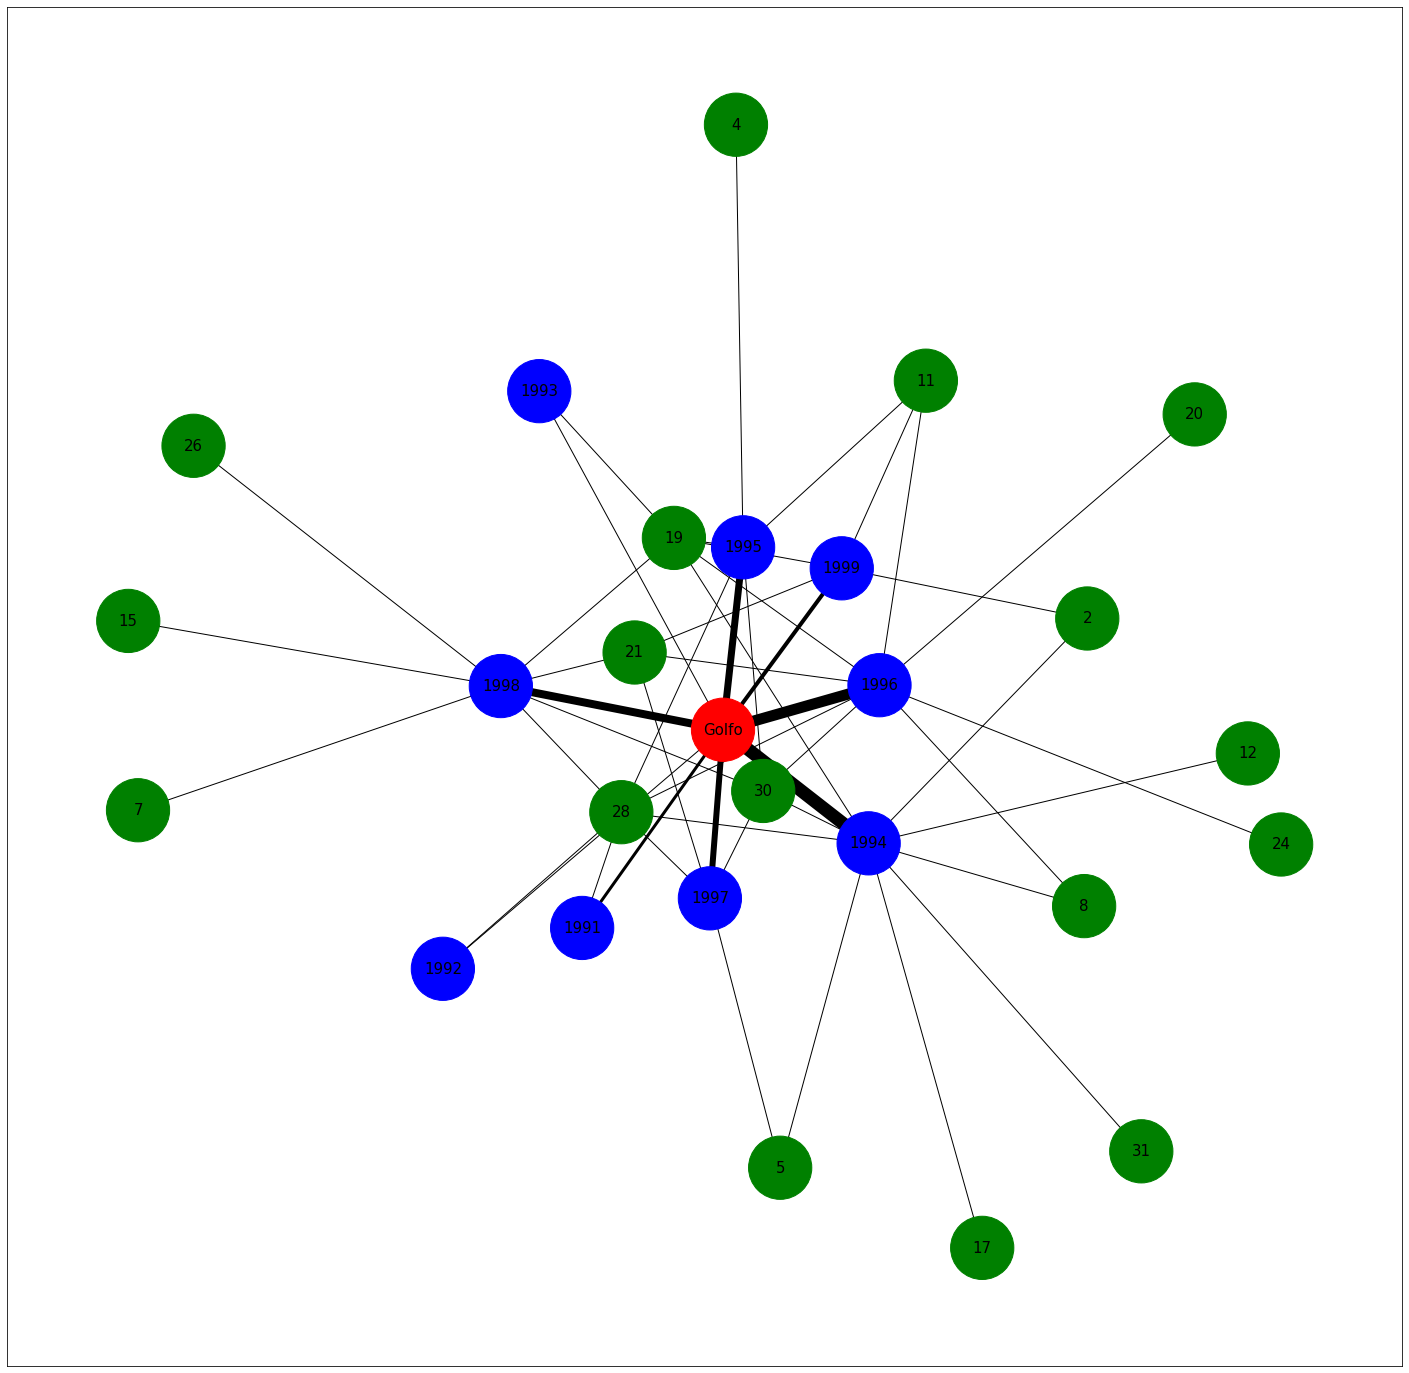

In [31]:
all_weights=[]
for (node1,node2,data) in net_golfo_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[]
for (node1,data) in net_golfo_9000.nodes(data=True):
        nodes_color.append(data['color']) 


unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_golfo_9000,seed=1234)

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_golfo_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_golfo_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_golfo_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_golfo_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [32]:
metrics(net_golfo_9000,all_metrics=True)

Gli edge della rete sono: 49
# ------------------------------------------------------------ #
I nodi della rete sono: 27
# ------------------------------------------------------------ #
La somma dei node degree è: 98

L'average degree di questa network è: 3.6296296296296298

I valori degree maggiori sono: 
      Node  Degree
17   1994      10
22   1996       9
26  Golfo       9
21   1998       8
14     28       7
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.1396011396011396
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness maggiori sono: 
      Node      Values
17   1994  105.850352
21   1998   78.652733
22   1996   73.572668
26  Golfo   72.758446
14     28   46.337302
# ------------------------------------------------------------ #
I valori della Closeness maggiori s

In [28]:
net_golfo_0010 = nx.Graph()
sXy_golfo_0010 = pd.read_csv('/Users/emanuele/Desktop/SNA/PROGETTO/state_year_Golfo_G0010.txt')
Network_Generator_For_Cartels(net_golfo_0010,sXy_golfo_0010,df_G0010,'Golfo')

In [35]:
nt = Network('1000px','1000px')

nt.from_nx(net_golfo_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.edges:
    node['weight'] = len(neighbor_map[node['id']])

nt.show_buttons(filter_=True)
nt.show('golfo_0010.html')

## NETWORK FAMIGLIE

In [33]:
y_1992 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1992','network_cartels_1992',1992)
y_1993 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1993','network_cartels_1993',1993)
y_1994 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1994','network_cartels_1994',1994)
y_1995 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1995','network_cartels_1995',1995)
y_1996 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1996','network_cartels_1996',1996)
y_1997 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1997','network_cartels_1997',1997)
y_1998 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1998','network_cartels_1998',1998)
y_1999 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1999','network_cartels_1999',1999)

y_9000 = pd.concat([y_1992,y_1993,y_1994,y_1995,y_1996,y_1997,y_1998,y_1999])

y_2000 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2000','network_cartels_2000',2000)
y_2001 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2001','network_cartels_2001',2001)
y_2002 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2002','network_cartels_2002',2002)
y_2003 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2003','network_cartels_2003',2003)
y_2004 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2004','network_cartels_2004',2004)
y_2005 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2005','network_cartels_2005',2005)
y_2006 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2006','network_cartels_2006',2006)
y_2007 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2007','network_cartels_2007',2007)
y_2008 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2008','network_cartels_2008',2008)
y_2009 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2009','network_cartels_2009',2009)
y_2010 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2010','network_cartels_2010',2010)

y_0010 = pd.concat([y_2000,y_2001,y_2002,y_2003,y_2004,y_2005,y_2006,y_2007,y_2008,y_2009,y_2010])



In [34]:
bi_grams_9000 = BiGram_Generator_Counter(y_9000)
bi_grams_0010 = BiGram_Generator_Counter(y_0010)

In [49]:
bi_grams_0010.sort_values(by='W',ascending=False)

,A,B,W
16,Golfo,Zetas,169
3,Golfo,Sinaloa,155
8,Sinaloa,Zetas,153
11,Beltran_Leyva,Sinaloa,133
15,Beltran_Leyva,Zetas,133
12,Beltran_Leyva,Golfo,130
1,Juarez,Sinaloa,117
4,Golfo,Juarez,112
18,Juarez,Zetas,105
0,Sinaloa,Tijuana,98


In [35]:
net_9000 = nx.Graph()
Network_Cartels_Meeting_Generator(bi_grams_9000,net_9000,'#0ee5ba')

net_0010 = nx.Graph()
Network_Cartels_Meeting_Generator(bi_grams_0010,net_0010,'#0ee5ba')

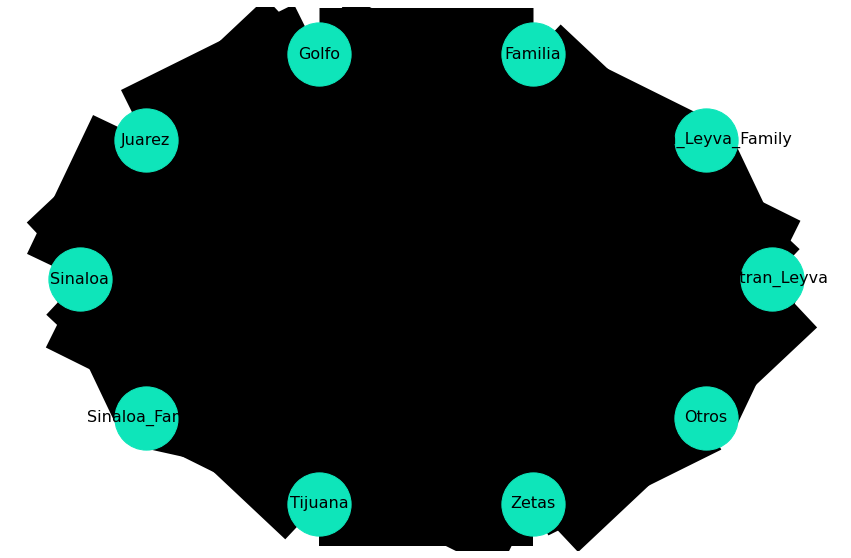

In [36]:
options = {
    "node_color" : '#0ee5ba', 
    "node_size" : 4000,
    "font_color" : 'black', 
    "font_size" : 16
}

pos=nx.circular_layout(net_0010)
all_weights=[]
for (node1,node2,data) in net_0010.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness
unique_weights = list(set(all_weights))
for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_0010.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_0010,pos,edgelist=weighted_edges,width=width)
nx.draw(net_0010, pos, with_labels=True,**options)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [5]:
#CREAZIONE CARTELLA

import os

cartella = "GeeksforGeeks"
  
# Parent Directory path
percorso_cartella = "/Users/emanuele/Desktop/SNA/PROGETTO"

path = os.path.join(percorso_cartella, cartella)
os.mkdir(path)

print("La cartella '% s' è stata creata con successo" % cartella)

La cartella 'GeeksforGeeks' è stata creata con successo


In [38]:
metrics(net_0010)

-> I link della rete sono: 45

-> Calcolo il degree di ogni singolo nodo della rete:
il nodo Beltran_Leyva ha degree: 9
il nodo Beltran_Leyva_Family ha degree: 9
il nodo Familia ha degree: 9
il nodo Golfo ha degree: 9
il nodo Juarez ha degree: 9
il nodo Sinaloa ha degree: 9
il nodo Sinaloa_Family ha degree: 9
il nodo Tijuana ha degree: 9
il nodo Zetas ha degree: 9
il nodo Otros ha degree: 9

La somma dei node degree è: 90

L'average degree di questa network è: 9.0

-> Densità della rete equivale a: 1.0

-> MATRICE DI ADIACENZA PESATA
